# seq to seq version 작성

## default version

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import numpy as np
import tensorflow as tf

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
rc('font', family='Malgun Gothic') #윈도우용, 한글깨짐 방지

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint

print("Python version:", sys.version)
print('tensorflow', tf.__version__)
print('numpy', np.__version__)

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
tensorflow 2.5.3
numpy 1.19.5


In [2]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [3]:
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}

pprint(source2idx)

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}


In [4]:
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}

pprint(target2idx)

{'<bos>': 1,
 '<eos>': 2,
 '<pad>': 0,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}


In [5]:
def preprocess(sequences, max_len, diction, mode='source'):
    assert mode in ['source', 'target'], 'source와 target 중 선택 필요'
    
    if mode == 'source' : 
        s_input = list(map(lambda sentence : [diction.get(token) for token in sentence], sequences))
        s_len = list(map(lambda sentence : len(sentence), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding='post', truncating='post')
        
        return s_len, s_input
    
    elif mode == 'target' : 
        t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
        t_input = list(map(lambda sentence : [diction.get(token) for token in sentence], t_input))
        t_len = list(map(lambda sentence : len(sentence), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding='post', truncating='post')
        
        t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
        t_output = list(map(lambda sentence : [diction.get(token) for token in sentence], sequences))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding='post', truncating='post')
    
        return t_len, t_input, t_output

In [6]:
s_max_len = 10
s_len, s_input = preprocess(sequences = sources, max_len = s_max_len,
                           diction = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 7, 5] [[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [7]:
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets, max_len = t_max_len,
                                       diction = target2idx, mode = 'target')
print(t_len, t_input, t_output)

[5, 5, 6, 6] [[ 1  4  7  3  2  0  0  0  0  0  0  0]
 [ 1 12  6 10  2  0  0  0  0  0  0  0]
 [ 1 12  5 11 13  2  0  0  0  0  0  0]
 [ 1 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  0  0  0  0  0  0  0  0  0]
 [12  6 10  0  0  0  0  0  0  0  0  0]
 [12  5 11 13  0  0  0  0  0  0  0  0]
 [12  6  9  8  0  0  0  0  0  0  0  0]]


In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [15]:
#hyper parameter

epochs = 200
batch_size = 4
learning_rate = 0.005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size // batch_size
embedding_dim = 32
units = 32

data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)

In [16]:
def gru(units):
    return tf.keras.layers.GRU(units, return_sequences=True,
                              return_state=True, recurrent_initializer = 'glorot_uniform')

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x, hidden, enc_output):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        output = tf.reshape(output, (-1, output.shape[2])) # output shape == (batch_size * 1, hidden_size)
        
        x = self.fc(output) # output shape == (batch_size * 1, vocab)
        
        return x, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.dec_units))

In [22]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

In [24]:
def loss_fucntion(real, pred):
    mask = 1 - np.equal(real,0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred) * mask
    
    return tf.reduce_mean(loss_)

In [25]:
optimizer = tf.keras.optimizers.Adam()

checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [ ]:
for epoch in range(epochs):
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for ii, (s_len, s_input, t_len, t_input, t_output): in enumerate(data):
            loss = 0
            with tf.GradientTape() as tape:
                enc_output, enc_hidden = encoder(s_input, hidden)
                dec_hidden = enc_hidden
                dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)
                
                for tt in range(1, t_input.shape[1]):
                    
                    predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                    loss += loss_function(t_input[:, tt], predictions)
                    dec_input = tf.expand_dims(t_input[:, tt], 1) #using teacher forcing ->>> 확인 필요
                    
            batch_loss = (loss / int(t_input.shape[1]))
            total_loss += batch_loss
            variables = endocer.variables * decoder.variables
            gradient = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradient, variables))
            
        if epoch % 10 == 0 :
            print('epoch {} loss {:.4f} batch loss {:.4f}'.format(epoch,
                                                                 total_loss / n_batch,
                                                                 batch_loss.numpy()))
            checkpoint,save(file_prefix = checkpoint_prefix)
            

In [ ]:
checkpoint_restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def prediction(sentence, encoder, decoder, inp_lang, targ_lang, 
               max_length_inp, max_length_targ):
    inputs = [inp_lang[ii] for ii in sentence.split(' ')]
    inputs = pad_sequences([inputs, maxlen=max_length_inp, padding='post'])
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder([inputs, hidden])
    
    for tt in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0].numpy())
        result += idx2target[predicted_id] + ' '
        
        if idx2target.get(predicted_id) == '<eos>':
            return result, sentence
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence

sentence = 'I feel hungry'

result, output_sentence = prediction(sentence, encoder, decoder,
                                    source2idx, target2idx,
                                    s_max_len, t_max_len)

print(sentence)
print(result)

## using attention

In [13]:
#hyper parameter 이전 부분까지는 같음

epochs = 100
batch_size = 4
learning_rate = 0.005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size // batch_size
embedding_dim = 32
units = 128

data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)

In [14]:
def gru(units):
    return tf.keras.layers.GRU(units, return_sequences=True,
                              return_state=True, recurrent_initializer = 'glorot_uniform',
                              recurrent_activation = 'sigmoid') #activation 추가됨

In [78]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention (기존 이후 추가되는 영역)
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        
        #attention위해서 추가됨
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        #기존 영역
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1) #임베딩과 attention 결합
        output, state = self.gru(x, initial_state = hidden)
        
        output = tf.reshape(output, (-1, output.shape[2])) # output shape == (batch_size * 1, hidden_size)
        
        x = self.fc(output) # output shape == (batch_size * 1, vocab)
        
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.dec_units))

In [79]:
# 동일 코드
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

def loss_fucntion(real, pred):
    mask = 1 - np.equal(real,0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred) * mask
    
    return tf.reduce_mean(loss_)

optimizer = tf.keras.optimizers.Adam()

checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

#create writer for tensorboard(신규 추가)
summary_writer = tf.summary.create_file_writer(logdir = checkpoint_dir)

In [80]:
# 동일 코드
for epoch in range(epochs):
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)

            for tt in range(1, t_input.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_fucntion(t_input[:, tt], predictions)
                dec_input = tf.expand_dims(t_input[:, tt], 1) #using teacher forcing ->>> 확인 필요

        batch_loss = (loss / int(t_input.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        gradient = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradient, variables))
            
    if epoch % 10 == 0 :
        print('epoch {} loss {:.4f} batch loss {:.4f}'.format(epoch,
                                                             total_loss / n_batch,
                                                             batch_loss.numpy()))
        checkpoint.save(file_prefix = checkpoint_prefix)

epoch 0 loss 0.0396 batch loss 0.9902
epoch 10 loss 0.0356 batch loss 0.8903
epoch 20 loss 0.0302 batch loss 0.7548
epoch 30 loss 0.0215 batch loss 0.5376
epoch 40 loss 0.0143 batch loss 0.3575
epoch 50 loss 0.0080 batch loss 0.2000
epoch 60 loss 0.0033 batch loss 0.0829
epoch 70 loss 0.0013 batch loss 0.0315
epoch 80 loss 0.0006 batch loss 0.0150
epoch 90 loss 0.0004 batch loss 0.0088


In [ ]:
# checkpoint_restore(tf.train.latest_checkpoint(checkpoint_dir))

In [81]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    inputs = [inp_lang[i] for i in sentence.split(' ')]
    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1,units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang['<bos>']], 0)
    
    for tt in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[tt] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += idx2target[predicted_id] + ' '
        
        if idx2target.get(predicted_id) == '<eos>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
    
    return result, sentence, attention_plot

In [82]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize' : 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    plt.show()

In [83]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, 
                                                inp_lang, targ_lang, max_length_inp, max_length_targ)
    print('Input : {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [76]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input : I feel hungry
Predicted translation: 나는 배가 고프다 <eos> 


C:\Users\10331\AppData\Local\Temp/ipykernel_10864/4264259835.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\10331\AppData\Local\Temp/ipykernel_10864/4264259835.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


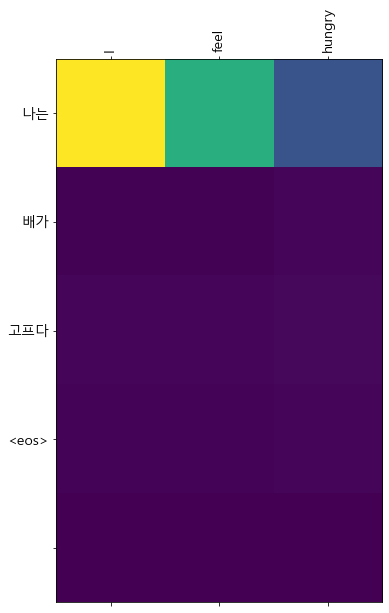

In [84]:
sentence = 'I feel hungry'

translate(sentence, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)